In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/Shareddrives/vae-asr/

Mounted at /content/drive
/content/drive/Shareddrives/vae-asr


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import sys
sys.path.append('/content/drive/Shareddrives/vae-asr/modules')
# from model import VAE
# help(VAE)
from data import MSA_Dataset
# help(MSA_Dataset)

## Run script to pre-process the VAE

Query sequence for PF00565_full: SND1_HUMAN/552-660

Query sequence for PF00041_full: TENA_HUMAN/804-884 (this is the same choice as original paper: https://github.com/BrooksResearchGroup-UM/PEVAE_Paper/blob/master/pfam_msa/script/proc_msa.py)

Query sequence for PF00067_full: A0A8J5V3X2_ZIZPA/310-424 (chosen for its sparsity so that eliminating sequences that have too many gaps where the query sequence has a letter does not result in very few remaining sequences)



In [3]:
MSA_id = "PF00067_full"
query_seq_id = "A0A8J5V3X2_ZIZPA/310-424"

In [4]:
# !grep {query_seq_id} data/pevae_real/{MSA_id}.txt

The script writes the processed MSA objects as `.pkl` files in the `output/` directory.

In [ ]:
! python scripts/proc_msa.py data/pevae_real/{MSA_id}.txt {query_seq_id}

# of sequences in raw MSA: 17984


Check resulting processed MSA

In [5]:
#Number of sequences
! wc -l ./output/{MSA_id}/seq_msa_char.txt

9767 ./output/PF00067_full/seq_msa_char.txt


In [6]:
#First few sequences
!head ./output/PF00565_full/seq_msa_char.txt | awk '{print $2}'

VMLSGVKCPSFKREADTPEPFAAEAKFFTESRLLQRDVQIIL.ESCPNQIILGTILHPNGNITELLLKEGFARCVDSMAYTQGAEKLRAAERSAKERKVRIWK
IRLHGIDTAETGQTCPGDWRCGAYATRRLTDLIDGRSVSCDALDRDAYNRVIARCYSDGEDLARALVAEGLAWAFTRYS.....DDYVSDEAHARADGRGVWR
IHLSSIRPPRLEGEGTYDIPYMFEAREFLRKKLIGKKVNVTVDYIAFSERTCATVAIGGINIAEALVSKGLATVIRYRQRSSHYDELLAAEARAIKNGKGLHS
VRLIGLDAPENLPR...PRCWARESTSALLRLAPRGSTVTLAFDRDDHRRQLRYVWTAGEFVNARQLAEGNAFALRVRPNVAHAEEFARLERRARAARKGLW.
IHLSSIRPPRLEGESAYDIPYMFEAREFLRKKLIGKKVNVTVDYISFSERTCATVSIGGINIAEALISKGLSTVIRYRQRSSHYDELLAAEARAIKNGKGLHS
VNLSSIRSPKMGNPRRKPAPYAREAKEFLRTRLIGQKVSVSMEYSDSKLMDFGSVFLVGPNVGELIVSRGFGTVIRHRDRSNHYDALLAAESRANSGKKGIH.
FVLGGIRAPKSARGPNKAEPFGQEAHDLATKRLTQRDVEVDVHSIDKVGGFIGELYINKESFAKILVEEGFATVHVYSAQAGNATELLGAEQRAKDARRGLWV
VTLAATRSPRAAAITNKSEELGDVARFFTESRLLHQDVTVSLLGLTSNTPFVATVTHAQGNIAAFLLQGGLARIVDHAGGPEEMGALRRAEADAKAAKKGIWH
VMLSGIKCPTFKREADVPEPFAAEAKFFTESRLLQRDVQIV.LESCHNQNILGTILHPNGNITELLLKEGFARCVDSIAYTRGADKLRAAERFAKERKLRIWR
VKVAGVITPQTAFNPRTADPLSEEAKNFVIRLVQQREVNVQVYTSDRGGNFISAVTLKGTNLSV

## Load data and instantiate dataset

In [7]:
## read multiple sequence alignment in binary representation
with open(f"./output/{MSA_id}/seq_msa_binary.pkl", 'rb') as file_handle:
    msa_binary = torch.tensor(pickle.load(file_handle))
# Number of sequences
n_seq = msa_binary.shape[0]
# Dimensions of one-hot encoding
nl = msa_binary.shape[1]
nc = msa_binary.shape[2]
# Print shape
msa_binary.shape

torch.Size([9767, 107, 21])

In [8]:
## each sequence has a label
with open(f"./output/{MSA_id}/keys_list.pkl", 'rb') as file_handle:
    msa_keys = pickle.load(file_handle)
msa_keys[:10]

['A0A8C4CNX3_9TELE/41-498',
 'A0A6D2KQW5_9BRAS/30-513',
 'A0A8K0MXP5_COCNU/37-492',
 'A0A6P5YD73_DURZI/55-522',
 'A0A0D3FSJ4_9ORYZ/51-514',
 'A0A2V1DIY2_9PLEO/30-468',
 'A0A8J6AVG1_GALPY/899-1088',
 'A0A168DGB0_CORFA/1-418',
 'A0A8H6P498_9EURO/256-505',
 'A0A7J6X3X1_THATH/28-493']

In [9]:
## sequences in msa are weighted
with open(f"./output/{MSA_id}/seq_weight.pkl", 'rb') as file_handle:
    seq_weight = pickle.load(file_handle)
seq_weight = seq_weight.astype(np.float32)
seq_weight[:10]

array([1.3613485e-04, 2.0739369e-04, 8.0609527e-05, 5.5940869e-05,
       1.0388179e-04, 1.8525257e-04, 5.8904512e-05, 1.3547979e-04,
       7.5113967e-05, 6.1428691e-05], dtype=float32)

In [10]:
data = MSA_Dataset(msa_binary, seq_weight, msa_keys)
# Show a random sample
print(data[100][0].shape)
data[100]

torch.Size([107, 21])


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 0.00010963139,
 'A0A0L1IWY7_ASPNO/723-1184')

We see that an item of the dataset contains the one-hot representation of the sequence, the weight assigned to the sequence (explained later), and the name of the sequence

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class LSTM_VAE(nn.Module):
    def __init__(self, nl, nc=21, dim_latent_vars=10, num_hidden_units=[256, 256]):
        """
        Our default is that the latent embeddings are dimension 10 and there are
        256 neurons in each of the hidden layers of the encoder and decoder
        """
        super(LSTM_VAE, self).__init__()

        ## num of amino acid types
        self.nc = nc

        ## length of sequences in the MSA
        self.nl = nl

        ## dimension of input
        self.dim_input = nc * nl

        ## dimension of latent space
        self.dim_latent_vars = dim_latent_vars

        ## num of hidden neurons in encoder and decoder networks
        self.num_hidden_units = num_hidden_units

        ## encoder
        # self.encoder_linears = nn.ModuleList()
        # self.encoder_linears.append(nn.Linear(self.dim_input, num_hidden_units[0]))
        # for i in range(1, len(num_hidden_units)):
        #     self.encoder_linears.append(nn.Linear(num_hidden_units[i-1], num_hidden_units[i]))

        # self.encoder_lstm = nn.LSTM(self.nc, num_hidden_units[0], 1, batch_first=True)
        # self.encoder_mu = nn.Linear(num_hidden_units[-1], dim_latent_vars)
        # self.encoder_logsigma = nn.Linear(num_hidden_units[-1], dim_latent_vars)
        self.encoder_lstm_mu = nn.LSTM(self.nc, dim_latent_vars, 1, batch_first=True)
        self.encoder_lstm_sigma = nn.LSTM(self.nc, dim_latent_vars, 1, batch_first=True)

        ## decoder
        self.decoder_linears = nn.ModuleList()
        self.decoder_linears.append(nn.Linear(dim_latent_vars, num_hidden_units[0]))
        for i in range(1, len(num_hidden_units)):
            self.decoder_linears.append(nn.Linear(num_hidden_units[i-1], num_hidden_units[i]))
        self.decoder_linears.append(nn.Linear(num_hidden_units[-1], self.dim_input))

    def encoder(self, x):
        '''
        encoder transforms x into latent space z
        '''
        # convert from matrix to vector by concatenating rows (which are one-hot vectors)
        # h = torch.flatten(x, start_dim=-2) # start_dim=-2 to maintain batch dimension
        # for T in self.encoder_linears:
        #     h = T(h)
        #     h = F.relu(h)

        # h, _ = self.encoder_lstm(x)
        # h = h[:, -1, :]
        # mu = self.encoder_mu(h)
        # sigma = torch.exp(self.encoder_logsigma(h))

        mu, _ = self.encoder_lstm_mu(x)
        mu = mu[:, -1, :]
        sigma, _ = self.encoder_lstm_sigma(x)
        sigma = torch.exp(sigma[:, -1, :])
        return mu, sigma

    def decoder(self, z):
        '''
        decoder transforms latent space z into p, which is the probability  of x being 1.
        '''
        h = z
        for i in range(len(self.decoder_linears)-1):
            h = self.decoder_linears[i](h)
            h = F.relu(h)
        h = self.decoder_linears[-1](h) #Should now have dimension nc*nl

        fixed_shape = tuple(h.shape[0:-1])
        h = torch.unsqueeze(h, -1)
        h = torch.reshape(h, fixed_shape + (-1, self.nc))
        log_p = F.log_softmax(h, dim = -1)
        #log_p = torch.reshape(log_p, fixed_shape + (-1,))

        return log_p

    def compute_weighted_elbo(self, x, weight):
        ## sample z from q(z|x)
        mu, sigma = self.encoder(x)
        eps = torch.randn_like(sigma)
        z = mu + sigma*eps

        ## compute log p(x|z)
        log_p = self.decoder(z)
        log_PxGz = torch.sum(x*log_p, [-1,-2]) # sum over both position and character dimension

        ## compute elbo
        elbo = log_PxGz - torch.sum(0.5*(sigma**2 + mu**2 - 2*torch.log(sigma) - 1), -1)
        weight = weight / torch.sum(weight)
        elbo = torch.sum(elbo*weight)

        return elbo

    def compute_elbo_with_multiple_samples(self, x, num_samples):
        '''
        Evidence lower bound is an lower bound of log P(x). Although it is a lower
        bound, we can use elbo to approximate log P(x).
        Using multiple samples to calculate the elbo makes it be a better approximation
        of log P(x).
        '''

        with torch.no_grad():
            # x = x.expand(num_samples, x.shape[0], x.shape[1], x.shape[2])
            mu, sigma = self.encoder(x)
            eps = torch.randn_like(mu)
            z = mu + sigma * eps
            log_Pz = torch.sum(-0.5*z**2 - 0.5*torch.log(2*z.new_tensor(np.pi)), -1)
            log_p = self.decoder(z)
            log_PxGz = torch.sum(x*log_p, [-1,-2]) # sum over both position and character dimension
            log_Pxz = log_Pz + log_PxGz

            log_QzGx = torch.sum(-0.5*(eps)**2 -
                                 0.5*torch.log(2*z.new_tensor(np.pi))
                                 - torch.log(sigma), -1)
            log_weight = (log_Pxz - log_QzGx).detach().data
            log_weight = log_weight.double()
            log_weight_max = torch.max(log_weight, 0)[0]
            log_weight = log_weight - log_weight_max
            weight = torch.exp(log_weight)
            elbo = torch.log(torch.mean(weight, 0)) + log_weight_max
            return elbo


## Instantiate model

In [12]:
# For architecture hyper-parameters, we rely on the defaults in the class definition
model = LSTM_VAE(nl = nl, nc = nc)

Let's check that our model processes data the way we want it to

In [13]:
#Encoding
one_hot_ary = data[100][0]
batch_one_hot_ary = torch.unsqueeze(one_hot_ary, 0)
latent_parameters = model.encoder(batch_one_hot_ary)
print(f"Mean and variance of latent vector:")
print(latent_parameters)
#Decoding
mn_z = latent_parameters[0]
recon_log_probs = model.decoder(mn_z)
print(f"Decoded output has shape {recon_log_probs.shape} and is given by:")
print(recon_log_probs)
probs = torch.exp(recon_log_probs.squeeze())
print("The probability for each amino acid in each position is:")
print(probs)
print("Rows should sum to 1: ")
print(torch.sum(probs, dim = 1))

Mean and variance of latent vector:
(tensor([[-0.1525, -0.1203, -0.1802,  0.0737, -0.0857, -0.2614, -0.2022, -0.0153,
          0.0207, -0.1515]], grad_fn=<SliceBackward0>), tensor([[0.8769, 1.0348, 1.0499, 0.8576, 1.0131, 0.8935, 1.2319, 0.9701, 0.9333,
         0.9465]], grad_fn=<ExpBackward0>))
Decoded output has shape torch.Size([1, 107, 21]) and is given by:
tensor([[[-3.0028, -3.1271, -2.9971,  ..., -3.0775, -3.0450, -3.0710],
         [-3.0170, -3.0657, -3.1120,  ..., -3.1630, -3.0219, -3.0229],
         [-3.0571, -3.0267, -3.0418,  ..., -3.0884, -3.0777, -3.1239],
         ...,
         [-3.0499, -3.0121, -3.0252,  ..., -3.0183, -3.0814, -3.0802],
         [-3.0117, -3.0074, -3.0252,  ..., -3.0825, -3.0829, -3.0389],
         [-3.0051, -3.1326, -3.0181,  ..., -2.9992, -3.0349, -2.9896]]],
       grad_fn=<LogSoftmaxBackward0>)
The probability for each amino acid in each position is:
tensor([[0.0496, 0.0438, 0.0499,  ..., 0.0461, 0.0476, 0.0464],
        [0.0489, 0.0466, 0.0445, 

## Train model

We'll use K-fold cross validation to evaluate the training of the VAE. What this means in practice is that we partition the data into K equal-sized folds. Then for each fold, we train the VAE (for 30 epochs) using all data outside that fold and evaluate the trained model with the data from the fold.

In [14]:
from sklearn.model_selection import KFold
K= 5
# Initialize the k-fold cross validation
kf = KFold(n_splits=K, shuffle=True)

In [15]:
for fold, (train_idx, valid_idx) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}")
    print("Indices of first 10 validation examples:")
    print(valid_idx[:10])
    print("-------")

Fold 1
Indices of first 10 validation examples:
[ 2  3  5 18 19 25 28 30 31 38]
-------
Fold 2
Indices of first 10 validation examples:
[ 1  6 11 12 15 29 32 34 41 51]
-------
Fold 3
Indices of first 10 validation examples:
[ 4  9 13 17 21 22 26 27 35 48]
-------
Fold 4
Indices of first 10 validation examples:
[ 0  7  8 20 23 24 36 37 47 50]
-------
Fold 5
Indices of first 10 validation examples:
[10 14 16 33 42 44 53 55 66 71]
-------


In [16]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if device == "cuda":
  model.cuda()

# Training hyperparameters
num_epochs = 500
dim_lat = 64
weight_decay = 0.01
batch_size = 128
verbose = False

# Define how to do an epoch of training
def train(model, device, train_loader, optimizer, epoch, verbose):

  model.train()
  running_loss = []

  for batch_idx, (msa, weight, _) in enumerate(train_loader):
    msa, weight = msa.to(device), weight.to(device)
    optimizer.zero_grad()
    loss = (-1)*model.compute_weighted_elbo(msa, weight)
    loss.backward()
    optimizer.step()
    loss_scalar = loss.data.item()
    if verbose:
      print("Epoch: {:>4}, Step: {:>4}, loss: {:>4.2f}".format(epoch, batch_idx, loss_scalar), \
            flush = True)
    running_loss.append(loss_scalar)

  return running_loss

# Define how to evaluate the model on the validation data
def eval(model, device, valid_loader):

  model.eval()
  running_elbos = []
  with torch.no_grad():
    for (msa, _, _) in valid_loader:
      msa = msa.to(device)
      elbo = model.compute_elbo_with_multiple_samples(msa, 1000)
      elbo_scalar = torch.sum(elbo).data.item()
      running_elbos.append(elbo_scalar)

  return running_elbos



cuda


In [17]:
train_loss = {}
valid_elbos = {}
for fold, (train_idx, valid_idx) in enumerate(kf.split(data)):

  print(f"Fold {fold + 1}")
  print("-------")

  # put the training and validation data into separate dataloaders
  train_loader = DataLoader(dataset = data,
                           batch_size = batch_size,
                           sampler = torch.utils.data.SubsetRandomSampler(train_idx))

  valid_loader = DataLoader(dataset = data,
                           batch_size = batch_size,
                           sampler = torch.utils.data.SubsetRandomSampler(valid_idx))

  # Instantiate a new model for this fold
  model = LSTM_VAE(nl = nl, nc = nc, dim_latent_vars=dim_lat).to(device)
  optimizer = optim.Adam(model.parameters(), weight_decay = weight_decay)

  # Define a key in the dictionaries for storing the losses and elbos for this fold
  train_loss[fold+1] = []
  valid_elbos[fold+1] = []

  for epoch in range(num_epochs):

    batch_losses = train(model, device, train_loader, optimizer, epoch, verbose)
    epoch_ave_train_loss = np.mean(batch_losses)
    print(f"Training loss for fold {fold + 1}, epoch {epoch}: {epoch_ave_train_loss}")
    train_loss[fold+1].append(epoch_ave_train_loss)

    batch_elbos = eval(model, device, valid_loader)
    epoch_ave_valid_elbo = np.mean(batch_elbos)
    print(f"Validation elbo for fold {fold + 1}, epoch {epoch}: {epoch_ave_valid_elbo}")
    valid_elbos[fold+1].append(epoch_ave_valid_elbo)

  model.cpu()
  torch.save(model.state_dict(), "./lstm_output/{}/vae_fold{}_dimlat{}_{}_{:.2f}.model".format(MSA_id, fold+1, dim_lat, num_epochs, weight_decay))


Streaming output truncated to the last 5000 lines.
Training loss for fold 1, epoch 4: 226.2987031013735
Validation elbo for fold 1, epoch 4: -183.2792555283746
Training loss for fold 1, epoch 5: 226.39288797686177
Validation elbo for fold 1, epoch 5: -186.46706487656087
Training loss for fold 1, epoch 6: 226.18800944666708
Validation elbo for fold 1, epoch 6: -185.84425971143386
Training loss for fold 1, epoch 7: 225.89177826912172
Validation elbo for fold 1, epoch 7: -187.2896179093749
Training loss for fold 1, epoch 8: 225.90841256418537
Validation elbo for fold 1, epoch 8: -186.726657860641
Training loss for fold 1, epoch 9: 225.59675647366433
Validation elbo for fold 1, epoch 9: -185.7054751966098
Training loss for fold 1, epoch 10: 225.8106728830645
Validation elbo for fold 1, epoch 10: -187.90614382256763
Training loss for fold 1, epoch 11: 225.64088587607108
Validation elbo for fold 1, epoch 11: -183.105823435372
Training loss for fold 1, epoch 12: 225.69934032809348
Validation 

In [18]:
MSA_id

'PF00067_full'

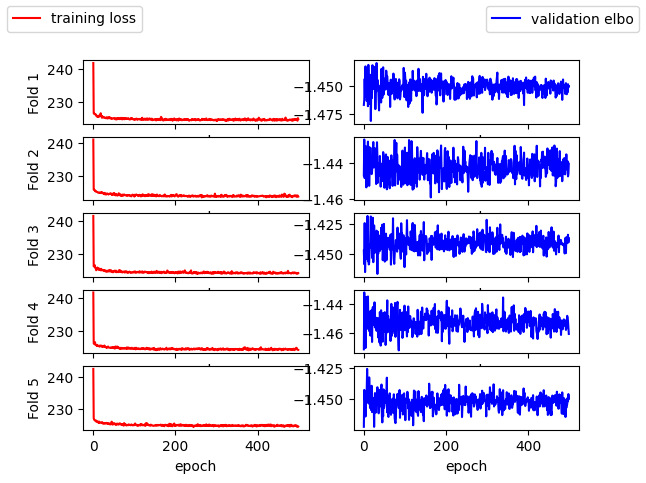

In [19]:
fig, axs = plt.subplots(5, 2, sharex = "all")
for k in range(K):
  axs[k,0].plot(train_loss[k+1], label = "training loss", color = 'r')
  #plt.plot(test_loss_epoch, label = "test", color = 'b')
  #plt.ylim((140, 180))
  axs[k,0].set_xlabel('epoch')
  axs[k,0].set_ylabel(f"Fold {k+1}")
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels,loc = "upper left")

for k in range(K):
  axs[k,1].plot([x/batch_size for x in valid_elbos[k+1]], label = "validation elbo", color = 'b')
  #plt.plot(test_loss_epoch, label = "test", color = 'b')
  #plt.ylim((140, 180))
  axs[k,1].set_xlabel('epoch')
handles, labels = axs[0,1].get_legend_handles_labels()
fig.legend(handles, labels,  loc = "upper right")
